# Check training

### controlla i training già finiti e aggiunge alla lista nuovi task che arrivano da una chiamata a diz_trials

In [26]:
from pathlib import Path
import os
import csv
import pandas as pd
from pandas import json_normalize
import yaml
import pickle

from Metrics import Metrics

folder = Path("/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8")
root_task = Path("/home/daniele/Documenti/Progetti/Networks/Embednet/head_train_tasks")
all_runs_csv = root_task / "head_run_tasks.csv"

### Bootstrap the dataframe

In [5]:
def give_configs(folder):
    file_list = []
    for root, dirs, files in os.walk(folder):
        for f in files:
            if f.endswith(".yml"):
                #file_list.append(os.path.join(root, f))               
                file_list.append(root)
    return file_list

file_list = give_configs(folder)

In [22]:
head_df = pd.DataFrame(data=file_list, columns=["folders"])

In [24]:
head_df['folders']

0      /home/daniele/Documenti/Progetti/Networks/Embe...
1      /home/daniele/Documenti/Progetti/Networks/Embe...
2      /home/daniele/Documenti/Progetti/Networks/Embe...
3      /home/daniele/Documenti/Progetti/Networks/Embe...
4      /home/daniele/Documenti/Progetti/Networks/Embe...
                             ...                        
306    /home/daniele/Documenti/Progetti/Networks/Embe...
307    /home/daniele/Documenti/Progetti/Networks/Embe...
308    /home/daniele/Documenti/Progetti/Networks/Embe...
309    /home/daniele/Documenti/Progetti/Networks/Embe...
310    /home/daniele/Documenti/Progetti/Networks/Embe...
Name: folders, Length: 311, dtype: object

In [170]:
head_df.to_csv(all_runs_csv, index=False)

In [37]:
# load the df
head_df = pd.read_csv(all_runs_csv)
head_df

,folders
0,/home/daniele/Documenti/Progetti/Networks/Embe...
1,/home/daniele/Documenti/Progetti/Networks/Embe...
2,/home/daniele/Documenti/Progetti/Networks/Embe...
3,/home/daniele/Documenti/Progetti/Networks/Embe...
4,/home/daniele/Documenti/Progetti/Networks/Embe...
...,...
306,/home/daniele/Documenti/Progetti/Networks/Embe...
307,/home/daniele/Documenti/Progetti/Networks/Embe...
308,/home/daniele/Documenti/Progetti/Networks/Embe...
309,/home/daniele/Documenti/Progetti/Networks/Embe...


In [115]:
str(Path(head_df.iloc[0].values[0]).parent)

'/home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/ER__Classi-1_nodi100_grafiX100__#__AE_CM__§32-32-32§__ELU+RELU__grphnorm__-xavier_normal_#__lr0001_ADAM_BCELoss'

In [4]:
def add_row(df_file, row_content):
    with open(df_file, 'a') as f:
        writer = csv.writer(f)
        writer.writerow([row_content])
        
def add_many_rows(df_file, rows):
    with open(df_file, 'a') as f:
        writer = csv.writer(f)
        for r in rows:
            writer.writerow([r])
    

#### Aggiungere tutte le nuove cartelle insieme, nel caso in cui il watchdog non era attivo mentre venivano create nuove cartelle

In [29]:
file_list = give_configs(folder)
print(f"In tutto ci sono {len(file_list )} files")
total_files = pd.DataFrame(file_list, columns=["folders"])
to_add = total_files[~total_files['folders'].isin(head_df['folders'])]

In tutto ci sono 311 files


In [33]:
add_many_rows(all_runs_csv, to_add.folders)

### Watchdog

In [31]:
import sys
import time
import logging
from watchdog.observers import Observer
from watchdog.events import LoggingEventHandler
from watchdog.events import FileSystemEventHandler

In [62]:
def watch_new_configs(filder):
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')
    event_handler = LoggingEventHandler()
    observer = Observer()
    observer.schedule(event_handler, folder, recursive=True)
    observer.start()
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
    observer.join()

In [139]:
    
class MyHandler(FileSystemEventHandler):
    #def on_any_event(self, event):
    #    print(event.event_type, event.src_path)

    def on_created(self, event):
        #print("on_created", event.src_path)
        #print(event.src_path.strip())
        if "§training_ended§" in event.src_path.strip():        
            #print("Execute your logic here!")            
            path = Path(event.src_path.strip()).parent
            add_row(all_runs_csv, path)
            print(f"salvato il path: {path}?")

In [140]:
event_handler = MyHandler()
observer = Observer()
observer.schedule(event_handler, path=folder, recursive=True)
observer.start()

salvato il path: /home/daniele/Documenti/Progetti/Networks/Embednet/output_plots/autoencoder/8/CM__[-22]_Classi-1_nodi150_grafiX50___#__AE_CM______§1-8-4-2§_______ELU+RELU__grphnorm__-xavier_normal_#__lr00005_ADAMW_BCELoss?


In [169]:
observer.stop()

### ora la parte che carica tutte le cartelle con i config e le metriche e le aggiunge a un df dei run totali

In [ ]:
pd.DataFrame(columns=[""])

In [38]:
#root_task / "head_run_tasks.csv"
list_metriche_loss_dims = ["metrics_train",
"metrics_test",
"totale_node_dim",
"totale_graph_dim",
 "train_loss",
"test_loss"]
metric_names = ["pr_auc", "euclid"]

list_dfs = []
for row in head_df.iterrows():
    #leggo un config per volta: ho un df da una riga, che poi concateno in un unico df
    root = Path(row[1].values[0] )
    conf = yaml.safe_load(open(root / "config.yml"))
    df = json_normalize(conf)
    df = df.astype('object')
    
    # aggiungo i risultati
    for m in list_metriche_loss_dims:
        col = f"risultati.{m}"
        file = root / (m +".pkl")
        if file.is_file():
            with open(file, 'rb') as f:
                list_values = pickle.load(f) 
                #print(list_values)
                if isinstance(list_values[0], Metrics):
                    for name in metric_names:
                        metrica_values = [m.get_metric(name) for m in list_values]
                        col = f"risultati.{m}_{name}" 
                        df.at[0, col] ='s' # forza un cast a object
                        df.at[0, col] = tuple(metrica_values)
                        #display(df[[col]])
                else:
                    df.at[0, col] ='s' # forza un cast a object
                    df.at[0, col] = tuple(list_values) # è meglio che i tipi delle colonne non sano mai liste
            
    
    df.columns = df.columns.str.split('.', expand=True)
    list_dfs.append(df)
    
final_df = pd.concat(list_dfs, axis=0)       
df = json_normalize(conf)
df.columns = df.columns.str.split('.', expand=True)

In [46]:
final_df['risultati'].dropna()#'all')

,metrics_train_pr_auc,metrics_train_euclid,metrics_test_pr_auc,metrics_test_euclid,totale_node_dim,totale_graph_dim,train_loss,test_loss
0,"(0.31744120410869936, 0.31732390353304474, 0.3...","(31.81299336751302, 31.77593739827474, 30.8459...","(0.32334382518116844, 0.3232187653885701, 0.31...","(20.88524119059245, 20.86052958170573, 20.2347...","(0.9773135781288147, 0.9912735819816589, -1.0,...","(0.9308590888977051, 0.7651475071907043, -1.0,...","(0.18482165038585663, 0.1842300146818161, 0.18...","(0.18482165038585663, 0.18482165038585663, 0.1..."
0,"(0.9211887036108544, 0.9211856109635345, 0.921...","(45.26628621419271, 45.24686177571615, 45.2272...","(0.9221218022601099, 0.9221200312312445, 0.922...","(29.678187052408855, 29.665451049804688, 29.65...","(1.0148916244506836, 1.0396605730056763, 0.998...","(1.0116562843322754, 1.0360798835754395, 1.064...","(3.392279624938965, 3.382178544998169, 3.36517...","(3.392279624938965, 3.392279624938965, 3.37522..."
0,"(0.9194918674617065, 0.9194918529374094, 0.919...","(113.37684122721355, 113.1936543782552, 113.01...","(0.9195264586369399, 0.9195263889681126, 0.919...","(74.21355692545573, 74.09371948242188, 73.9741...","(1.0758453607559204, 1.0896456241607666, 1.073...","(1.1725538969039917, 1.0206300020217896, 1.541...","(0.8559941649436951, 0.8561564087867737, 0.853...","(0.8559941649436951, 0.8559942245483398, 0.853..."
0,"(0.09910857142857143, 0.09910857142857143, 0.0...","(15.52059555053711, 15.52059555053711, 15.5205...","(0.09813333333333334, 0.09813333333333334, 0.0...","(10.110500971476236, 10.110500971476236, 10.11...","(-0.03588457778096199, -0.03588457778096199, -...","(-0.03469075635075569, -0.03469075635075569, -...","(9.813333511352539, 9.910857200622559, 9.91085...","(9.813333511352539, 9.813333511352539, 9.81333..."
0,"(0.9195175717940989, 0.9195173539904409, 0.919...","(197.1449178059896, 196.71089680989584, 196.27...","(0.9193476353361184, 0.9193473818313371, 0.919...","(129.06139119466147, 128.77737426757812, 128.4...","(0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1...","(0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1...","(0.6928524374961853, 0.6928544640541077, 0.690...","(0.6928524374961853, 0.6928524374961853, 0.690..."
...,...,...,...,...,...,...,...,...
0,"(0.15149080878846452, 0.15148938606046924, 0.1...","(18.976795196533203, 18.95708465576172, 18.898...","(0.16445236887955794, 0.1644513147857516, 0.16...","(12.489145914713541, 12.476585388183594, 12.43...","(0.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, ...","(0.0, 0.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, ...","(0.4848259389400482, 0.4814951717853546, 0.480...","(0.4848259389400482, 0.4848259389400482, 0.484..."
0,"(0.09796, 0.09796, 0.09796, 0.09796, 0.09796, ...","(30.860799153645832, 30.860799153645832, 30.86...","(0.0984, 0.0984, 0.0984, 0.0984, 0.0984, 0.098...","(20.248457590738933, 20.248457590738933, 20.24...","(0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1...","(0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1...","(9.84000015258789, 9.795999526977539, 9.795999...","(9.84000015258789, 9.84000015258789, 9.8400001..."
0,"(0.09940785714285715, 0.09940785714285715, 0.0...","(124.3521016438802, 124.3521016438802, 124.352...","(0.09955166666666666, 0.09955166666666666, 0.0...","(81.46642049153645, 81.46642049153645, 81.4664...","(0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1...","(0.0, 0.0, 0.0, -1.0, 0.0, -1.0, 0.0, -1.0, -1...","(9.955166816711426, 9.94078540802002, 9.940785...","(9.955166816711426, 9.955166816711426, 9.95516..."
0,"(0.12783702574122807, 0.12783664404330877, 0.1...","(166.31465657552084, 165.99097696940103, 165.6...","(0.12809463120764364, 0.1280942567057044, 0.12...","(108.8886006673177, 108.6770528157552, 108.465...","(1.0097239017486572, 1.0096349716186523, 1.011...","(1.0521632432937622, 1.0543012619018555, 1.048...","(0.5462543964385986, 0.5461999177932739, 0.544...","(0.5462543964385986, 0.5462543964385986, 0.544..."


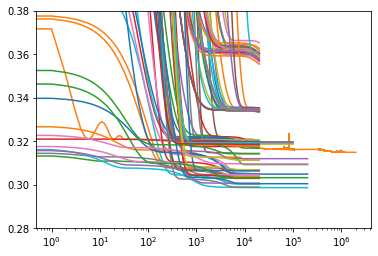

In [67]:
import matplotlib.pyplot as plt

for tl in final_df['risultati'].dropna()['train_loss']:#.astype('float')#.plot()
    plt.plot(list(map(float, tl)))
    
plt.ylim(0.28,0.38)
plt.xscale('log')
plt.show()